In [183]:
import pandas as pd
import numpy as np
from io import BytesIO
import matplotlib.pyplot as plt
import json

import minio_communication
from transform import *

In [200]:
def get_seats_dict(df, name_sep=','):
    seats_dict = {}
    for x in df.to_dict(orient="records"):
        name = x['party,seats'].split(name_sep)[0].strip()
        seats_dict[name] = int(x['party,seats'].split(',')[1].strip())
    return seats_dict

In [216]:
client = minio_communication.get_client()

minio_2019_config = minio_communication.get_minio_bucket_configuration(2019)
minio_2023_config = minio_communication.get_minio_bucket_configuration(2023)

districts_2019 = load_districts(client, minio_2019_config, 2019)
districts_2023 = load_districts(client, minio_2023_config, 2023)

results_2019 = load_results(client, minio_2019_config, 2019)
results_2023 = load_results(client, minio_2023_config, 2023)

seats = {}
info = {}
for year, config in [(2019, minio_2019_config), (2023, minio_2023_config)]:
    seats[year] = {}
    info[year] = {}
    for cls in Apportionment.__subclasses__() + [ConstituencialDHondtNoThreshold, ConstituencialSainteLagueNoThreshold]:
        obj = seats_obj_name(cls)
        info_obj = additional_info_obj_name(cls)
        resp = client.get_object(config.transformed_data_bucket, obj)
        seats[year][cls.name()] = pd.read_csv(BytesIO(resp.read()), sep=";")
        resp = client.get_object(config.transformed_data_bucket, info_obj)
        info[year][cls.name()] = pd.read_csv(BytesIO(resp.read()), sep=";") # TODO: unpickle?

# Apportionment Systems Comparison 
### Based on the 2019 and 2023 Polish Parliamentary Elections

This notebook compares the results of the 2019 and 2023 Polish Parliamentary Elections using different apportionment systems. The results of the elections are based on the official results published by the National Electoral Commission (PKW).

#### Districts
The chagnes between 2019 and 2023 are neglibile.

In [192]:
print("2019 Totals:")
districts_2019[['Liczba mandatów', "Liczba kandydatów", "Mieszkańcy", "Wyborcy"]].sum(axis=0, numeric_only=True)

2019 Totals:


Liczba mandatów           460
Liczba kandydatów        5111
Mieszkańcy           36910074
Wyborcy              30071458
dtype: int64

In [193]:
print("2023 Totals:")
districts_2023[['Liczba mandatów', "Liczba kandydatów", "Mieszkańcy", "Wyborcy"]].sum(axis=0, numeric_only=True)

2023 Totals:


Liczba mandatów           460
Liczba kandydatów        6333
Mieszkańcy           35858930
Wyborcy              29091621
dtype: int64

In [52]:
districts_2019["Procent mieszkańców"] = 100 *  districts_2019["Mieszkańcy"] / districts_2019["Mieszkańcy"].sum()
districts_2019["Procent wyborców"] = 100 *  districts_2019["Wyborcy"] / districts_2019["Wyborcy"].sum()
districts_2019["Procent mandatów"] = 100 *  districts_2019["Liczba mandatów"] / districts_2019["Liczba mandatów"].sum()

columns = ["Siedziba OKW", "Mieszkańcy", "Wyborcy", "Liczba mandatów", "Procent mieszkańców", "Procent wyborców", "Procent mandatów"]

In [53]:
print("Biggest districts by population:")
districts_2019.sort_values(by="Mieszkańcy", ascending=False).head(10)[columns]

Biggest districts by population:


,Siedziba OKW,Mieszkańcy,Wyborcy,Liczba mandatów,Procent mieszkańców,Procent wyborców,Procent mandatów
18,Warszawa,1674506,1701541,20,4.536718,5.658326,4.347826
22,Rzeszów,1241140,984494,15,3.362605,3.273849,3.260870
32,Kielce,1222607,997692,16,3.312394,3.317737,3.478261
2,Wrocław,1201333,993744,14,3.254756,3.304609,3.043478
25,Słupsk,1191547,928375,14,3.228243,3.087230,3.043478
5,Lublin,1162325,934842,15,3.149073,3.108735,3.260870
23,Białystok,1146820,919130,14,3.107065,3.056486,3.043478
12,Kraków,1142182,942910,14,3.094499,3.135565,3.043478
19,Warszawa,1088736,850607,12,2.949699,2.828619,2.608696
24,Gdańsk,1019416,823001,12,2.761891,2.736818,2.608696


In [61]:
print("Biggest districts by voters:")
districts_2019.sort_values(by="Wyborcy", ascending=False).head(10)[columns]

Biggest districts by voters:


,Siedziba OKW,Mieszkańcy,Wyborcy,Liczba mandatów,Procent mieszkańców,Procent wyborców,Procent mandatów
18,Warszawa,1674506,1701541,20,4.536718,5.658326,4.347826
32,Kielce,1222607,997692,16,3.312394,3.317737,3.478261
2,Wrocław,1201333,993744,14,3.254756,3.304609,3.043478
22,Rzeszów,1241140,984494,15,3.362605,3.273849,3.260870
12,Kraków,1142182,942910,14,3.094499,3.135565,3.043478
5,Lublin,1162325,934842,15,3.149073,3.108735,3.260870
25,Słupsk,1191547,928375,14,3.228243,3.087230,3.043478
23,Białystok,1146820,919130,14,3.107065,3.056486,3.043478
19,Warszawa,1088736,850607,12,2.949699,2.828619,2.608696
24,Gdańsk,1019416,823001,12,2.761891,2.736818,2.608696


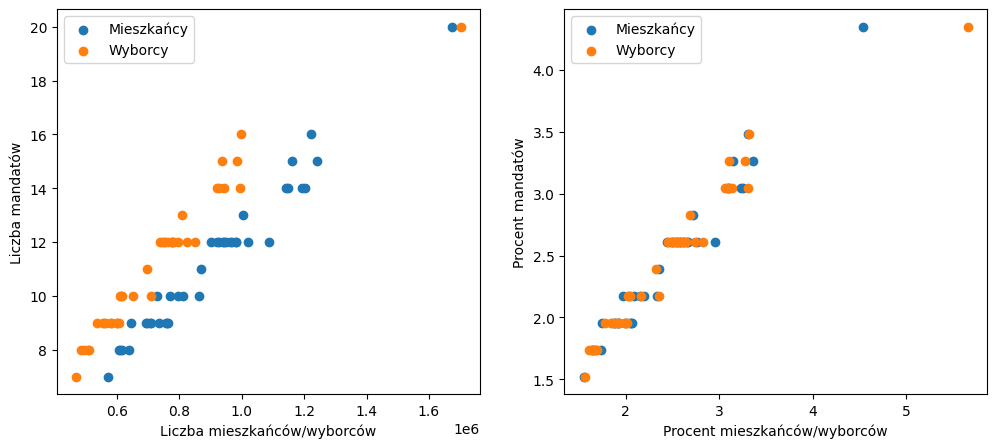

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].scatter(districts_2019["Mieszkańcy"], districts_2019["Liczba mandatów"], label="Mieszkańcy")
ax[0].scatter(districts_2019["Wyborcy"], districts_2019["Liczba mandatów"], label="Wyborcy")
ax[0].set_xlabel("Liczba mieszkańców/wyborców")
ax[0].set_ylabel("Liczba mandatów")
ax[0].legend()

ax[1].scatter(districts_2019["Procent mieszkańców"], districts_2019["Procent mandatów"], label="Mieszkańcy")
ax[1].scatter(districts_2019["Procent wyborców"], districts_2019["Procent mandatów"], label="Wyborcy")
ax[1].set_xlabel("Procent mieszkańców/wyborców")
ax[1].set_ylabel("Procent mandatów")
ax[1].legend()

plt.show()

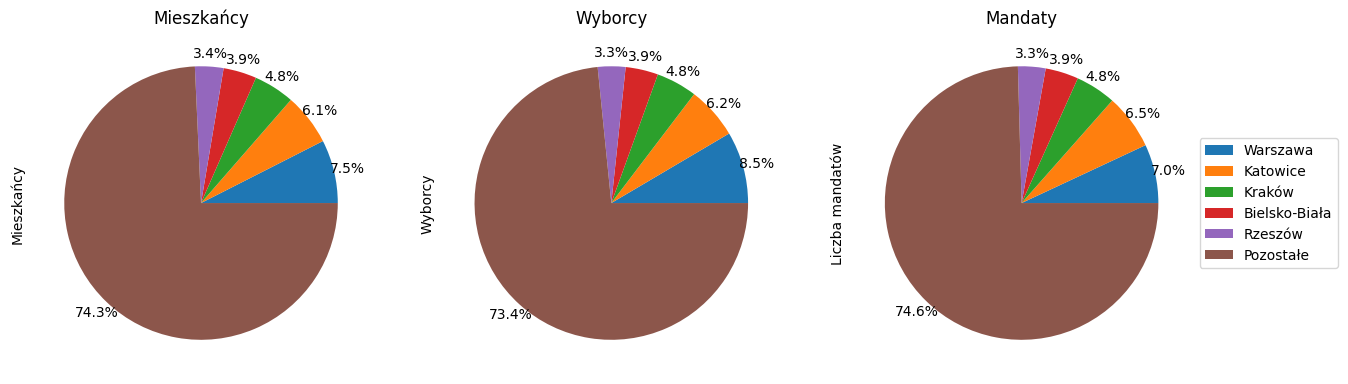

In [100]:
aggregated = districts_2019.groupby("Siedziba OKW").sum()

biggest_districts = aggregated.sort_values(by="Mieszkańcy", ascending=False).head(5)

rest = aggregated.sort_values(by="Mieszkańcy", ascending=False).tail(aggregated.shape[0] - 5).sum(axis=0)

biggest_districts.loc["Pozostałe"] = rest

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

biggest_districts["Mieszkańcy"].plot.pie(autopct='%1.1f%%', pctdistance=1.1, labels=None, title="Mieszkańcy", ax=ax[0])
biggest_districts["Wyborcy"].plot.pie(autopct='%1.1f%%', pctdistance=1.1, labels=None, title="Wyborcy", ax=ax[1])
biggest_districts["Liczba mandatów"].plot.pie(autopct='%1.1f%%', pctdistance=1.1, labels=None, title="Mandaty", ax=ax[2])

ax[2].legend(labels=biggest_districts.index, loc="center left", bbox_to_anchor=(1, 0.5))

plt.show()


#### Voting Results

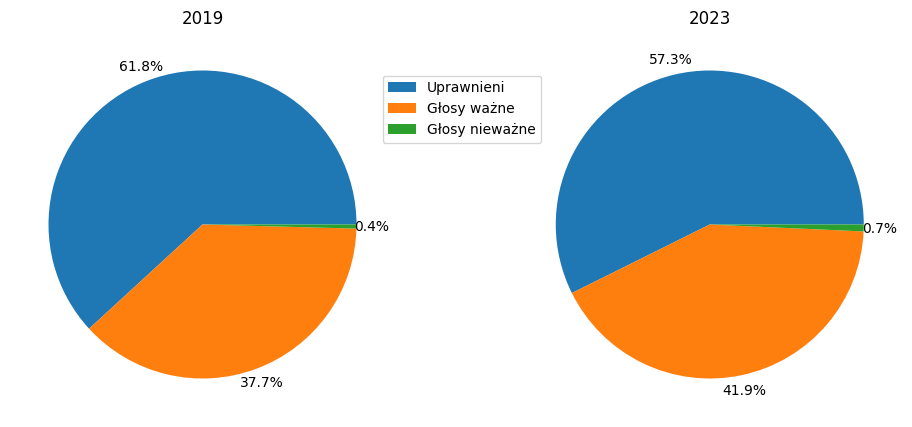

In [194]:
agg_2019 = results_2019.sum(axis=0, numeric_only=True)
agg_2023 = results_2023.sum(axis=0, numeric_only=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
cols = [
    "Liczba wyborców uprawnionych do głosowania",
    "Liczba głosów ważnych oddanych łącznie na wszystkie listy kandydatów",
    "Liczba głosów nieważnych"
]
agg_2019[cols].plot.pie(autopct='%1.1f%%', pctdistance=1.1, labels=None, title="2019", ax=ax[0])

agg_2023[cols].plot.pie(autopct='%1.1f%%', pctdistance=1.1, labels=None, title="2023", ax=ax[1])

ax[0].legend(labels=["Uprawnieni", "Głosy ważne", "Głosy nieważne"], loc="center left", bbox_to_anchor=(0.95, 0.8))

plt.show()

2019:
KOMITET WYBORCZY PRAWO I SPRAWIEDLIWOŚĆ - ZPOW-601-9/19                               8051935.0
KOALICYJNY KOMITET WYBORCZY KOALICJA OBYWATELSKA PO .N IPL ZIELONI - ZPOW-601-6/19    5060355.0
KOMITET WYBORCZY SOJUSZ LEWICY DEMOKRATYCZNEJ - ZPOW-601-1/19                         2319946.0
KOMITET WYBORCZY POLSKIE STRONNICTWO LUDOWE - ZPOW-601-19/19                          1578523.0
KOMITET WYBORCZY KONFEDERACJA WOLNOŚĆ I NIEPODLEGŁOŚĆ - ZPOW-601-5/19                 1256953.0
KOMITET WYBORCZY WYBORCÓW KOALICJA BEZPARTYJNI I SAMORZĄDOWCY - ZPOW-601-10/19         144773.0
KOMITET WYBORCZY WYBORCÓW MNIEJSZOŚĆ NIEMIECKA - ZPOW-601-15/19                         32094.0
KOMITET WYBORCZY SKUTECZNI PIOTRA LIROYA-MARCA - ZPOW-601-17/19                         18918.0
KOMITET WYBORCZY AKCJA ZAWIEDZIONYCH EMERYTÓW RENCISTÓW - ZPOW-601-21/19                 5448.0
KOMITET WYBORCZY PRAWICA - ZPOW-601-20/19                                                1765.0
dtype: float64

2023:
KOMITET WYBO

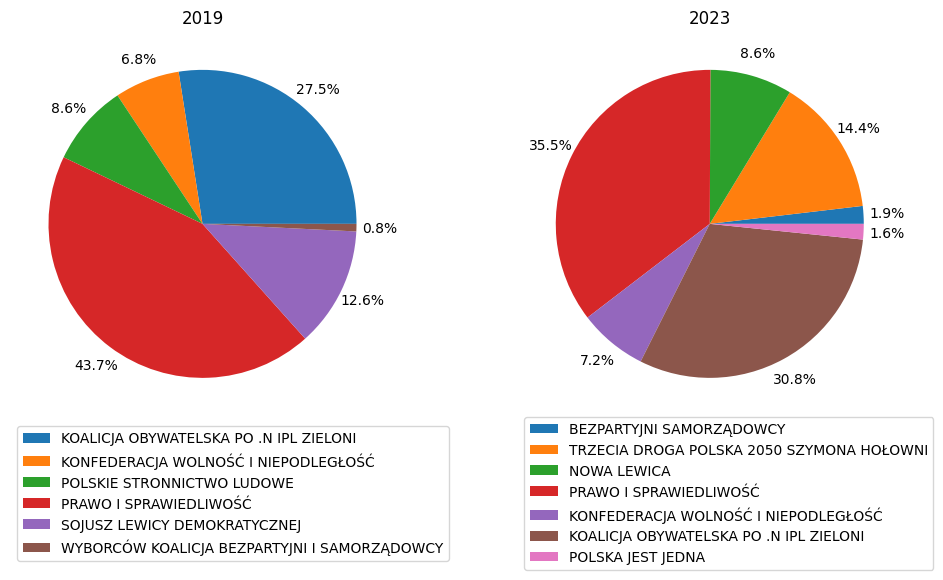

In [195]:
agg_2019 = results_2019.sum(axis=0, numeric_only=True)
agg_2023 = results_2023.sum(axis=0, numeric_only=True)

parties_2019 = agg_2019.filter(regex="KOMITET")
parties_2023 = agg_2023.filter(regex="KOMITET")
print("2019:")
print(parties_2019.sort_values(ascending=False))
print("\n2023:")
print(parties_2023.sort_values(ascending=False))

parties_2019 = parties_2019[parties_2019 > 100000]
parties_2023 = parties_2023[parties_2023 > 100000]

parties_2019.index = parties_2019.index.map(lambda x: x.split("WYBORCZY")[1].split("-")[0].strip())
parties_2023.index = parties_2023.index.map(lambda x: x.split("WYBORCZY")[1].split("-")[0].strip())

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

parties_2019.plot.pie(autopct='%1.1f%%', pctdistance=1.15, labels=None, title="2019", ax=ax[0])
parties_2023.plot.pie(autopct='%1.1f%%', pctdistance=1.15, labels=None, title="2023", ax=ax[1])

ax[0].legend(labels=parties_2019.index, loc="center left", bbox_to_anchor=(0, -0.2))
ax[1].legend(labels=parties_2023.index, loc="center left", bbox_to_anchor=(0, -0.2))

plt.show()

## Pipeline Description

The pipeline consists of the following steps:
1. Data loading -- Given the official results we download the data and store it in Minio.
2. Data processing -- We process the data and store it in Minio.
3. Results visualization -- By connecting with minio we visualize the results inside this notebook

What is worth noting, is that steps 1 and 2 are fully automated and can be easily
reused for other elections and extended for other systems.

We achieve that by separating the stages of the pipeline into separate programs that just 
need to ensure that the data is stored in the correct format at the end of each stage
and by using the class system that allows us to add new apportionment systems without
changing the code of the pipeline.

## Methods

We compare the results of the elections using the two most popular apportionment systems: the [D'Hondt method](https://en.wikipedia.org/wiki/D%27Hondt_method) and the [Sainte-Laguë method](https://en.wikipedia.org/wiki/Webster/Sainte-Lagu%C3%AB_method),
their regional and globale variants, together with the default thresholds and without them.

Additionally we compare them with two other apportionment systems proposed by Grzegorz:

* Square D'Hondt method
* Fair Vote Weight D'Hondt method


In [4]:
# TODO: Some analysis of the raw data that motivates the need for using methods and those two new methods

## Results

Here we present a brief graphical summary of the results that we obtained from the pipeline.

In [220]:
def present_methods(m1, m2, l1="D'Hondt", l2="Sainte-Lague"):
    seats_2019_d = get_seats_dict(seats[2019][m1.name()], '-')
    seats_2023_d = get_seats_dict(seats[2023][m1.name()])
    seats_2019_s = get_seats_dict(seats[2019][m2.name()], '-')
    seats_2023_s = get_seats_dict(seats[2023][m2.name()])

    all_parites = set(seats_2019_d.keys()).union(set(seats_2023_d.keys()))
    party_to_num = {p: i for i, p in enumerate(all_parites)}
    seats_2019_d = {party_to_num[p]: s for p, s in seats_2019_d.items()}
    seats_2023_d = {party_to_num[p]: s for p, s in seats_2023_d.items()}
    seats_2019_s = {party_to_num[p]: s for p, s in seats_2019_s.items()}
    seats_2023_s = {party_to_num[p]: s for p, s in seats_2023_s.items()}

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    width = 0.35
    inds = {
        2019: np.arange(len(seats_2019_d)),
        2023: np.arange(len(seats_2023_d))
    }

    for i, (year, sd, ss) in enumerate([(2019, seats_2019_d, seats_2019_s), (2023, seats_2023_d, seats_2023_s)]):
        ax[i].bar(inds[year] - width/2, sd.values(), width, label=l1)
        ax[i].bar(inds[year] + width/2, ss.values(), width, label=l2)
        ax[i].set_xticks(inds[year])
        ax[i].set_xticklabels(sd.keys())
        ax[i].set_title(year)
        ax[i].legend()

    ax[0].axhline(230, color='black', linestyle='--')
    ax[1].axhline(230, color='black', linestyle='--')

    print('\n'.join([f"{i}: {p}" for p, i in party_to_num.items()]))
    plt.show()

### Dhondt Method vs. Sainte-Lague Method

0: KOMITET WYBORCZY KONFEDERACJA WOLNOŚĆ I NIEPODLEGŁOŚĆ
1: KOMITET WYBORCZY WYBORCÓW MNIEJSZOŚĆ NIEMIECKA
2: KOMITET WYBORCZY PRAWO I SPRAWIEDLIWOŚĆ
3: KOMITET WYBORCZY NOWA LEWICA
4: KOALICYJNY KOMITET WYBORCZY TRZECIA DROGA POLSKA 2050 SZYMONA HOŁOWNI - POLSKIE STRONNICTWO LUDOWE
5: KOMITET WYBORCZY POLSKIE STRONNICTWO LUDOWE
6: KOMITET WYBORCZY SOJUSZ LEWICY DEMOKRATYCZNEJ
7: KOALICYJNY KOMITET WYBORCZY KOALICJA OBYWATELSKA PO .N IPL ZIELONI


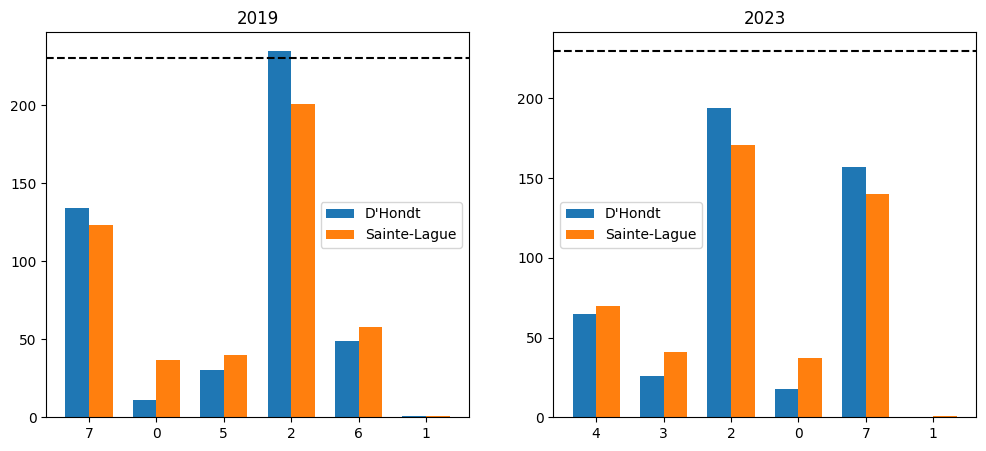

In [221]:
present_methods(ConstituencialDHondt, ConstituencialSainteLague)

### How does the global seat allocation affect the results?

0: KOMITET WYBORCZY KONFEDERACJA WOLNOŚĆ I NIEPODLEGŁOŚĆ
1: KOMITET WYBORCZY PRAWO I SPRAWIEDLIWOŚĆ
2: KOMITET WYBORCZY WYBORCÓW MNIEJSZOŚĆ NIEMIECKA
3: KOMITET WYBORCZY NOWA LEWICA
4: KOALICYJNY KOMITET WYBORCZY TRZECIA DROGA POLSKA 2050 SZYMONA HOŁOWNI - POLSKIE STRONNICTWO LUDOWE
5: KOMITET WYBORCZY POLSKIE STRONNICTWO LUDOWE
6: KOMITET WYBORCZY SOJUSZ LEWICY DEMOKRATYCZNEJ
7: KOALICYJNY KOMITET WYBORCZY KOALICJA OBYWATELSKA PO .N IPL ZIELONI


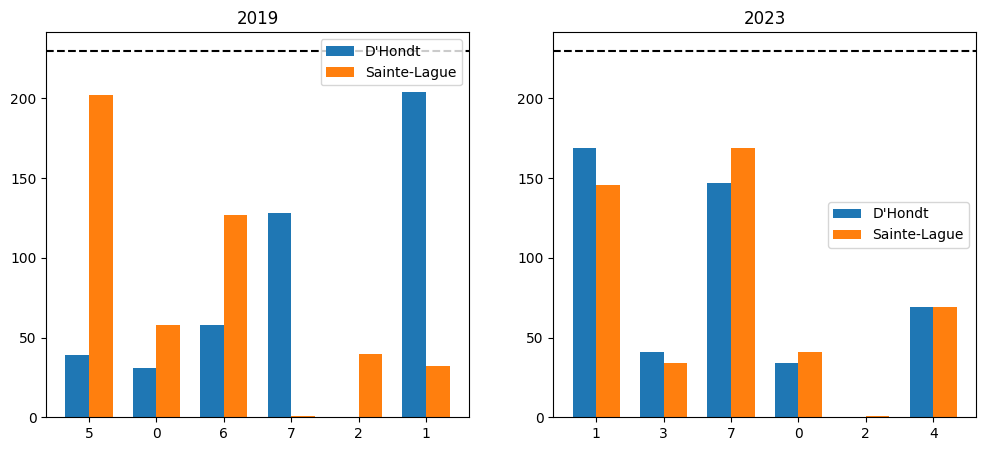

In [222]:
present_methods(GlobalDHondt, GlobalSainteLague)

### How does removing the thresholds affect the results?

0: KOMITET WYBORCZY WYBORCÓW RUCHU DOBROBYTU I POKOJU
1: KOMITET WYBORCZY NORMALNY KRAJ
2: KOMITET WYBORCZY PRAWICA
3: KOMITET WYBORCZY KONFEDERACJA WOLNOŚĆ I NIEPODLEGŁOŚĆ
4: KOMITET WYBORCZY WYBORCÓW MNIEJSZOŚĆ NIEMIECKA
5: KOMITET WYBORCZY NOWA LEWICA
6: KOMITET WYBORCZY POLSKIE STRONNICTWO LUDOWE
7: KOMITET WYBORCZY SOJUSZ LEWICY DEMOKRATYCZNEJ
8: KOMITET WYBORCZY AKCJA ZAWIEDZIONYCH EMERYTÓW RENCISTÓW
9: KOMITET WYBORCZY ANTYPARTIA
10: KOMITET WYBORCZY WYBORCÓW KOALICJA BEZPARTYJNI I SAMORZĄDOWCY
11: KOALICYJNY KOMITET WYBORCZY KOALICJA OBYWATELSKA PO .N IPL ZIELONI
12: KOMITET WYBORCZY BEZPARTYJNI SAMORZĄDOWCY
13: KOMITET WYBORCZY POLSKA JEST JEDNA
14: KOMITET WYBORCZY PRAWO I SPRAWIEDLIWOŚĆ
15: KOMITET WYBORCZY SKUTECZNI PIOTRA LIROYA
16: KOALICYJNY KOMITET WYBORCZY TRZECIA DROGA POLSKA 2050 SZYMONA HOŁOWNI - POLSKIE STRONNICTWO LUDOWE
17: KOMITET WYBORCZY RUCH NAPRAWY POLSKI


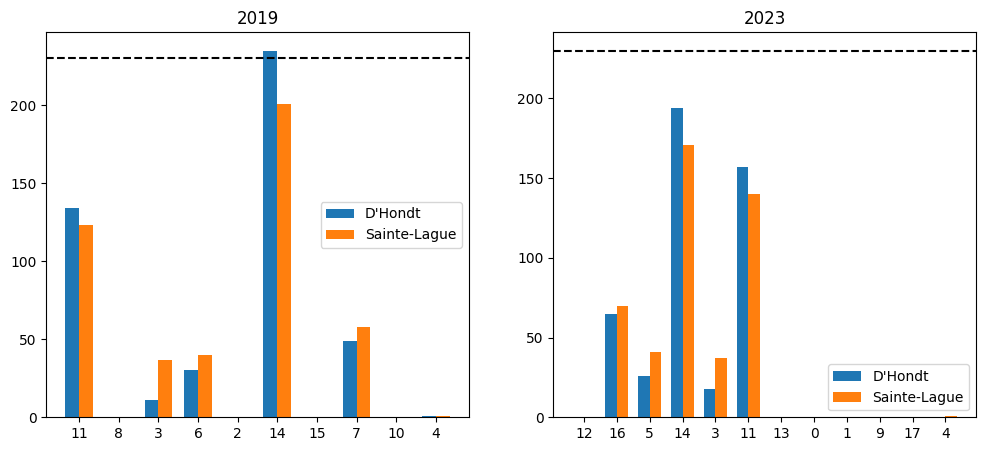

In [223]:
present_methods(ConstituencialDHondtNoThreshold, ConstituencialSainteLagueNoThreshold)

### Squared Dhondt Method

0: KOMITET WYBORCZY KONFEDERACJA WOLNOŚĆ I NIEPODLEGŁOŚĆ
1: KOMITET WYBORCZY WYBORCÓW MNIEJSZOŚĆ NIEMIECKA
2: KOMITET WYBORCZY PRAWO I SPRAWIEDLIWOŚĆ
3: KOMITET WYBORCZY NOWA LEWICA
4: KOALICYJNY KOMITET WYBORCZY TRZECIA DROGA POLSKA 2050 SZYMONA HOŁOWNI - POLSKIE STRONNICTWO LUDOWE
5: KOMITET WYBORCZY POLSKIE STRONNICTWO LUDOWE
6: KOMITET WYBORCZY SOJUSZ LEWICY DEMOKRATYCZNEJ
7: KOALICYJNY KOMITET WYBORCZY KOALICJA OBYWATELSKA PO .N IPL ZIELONI


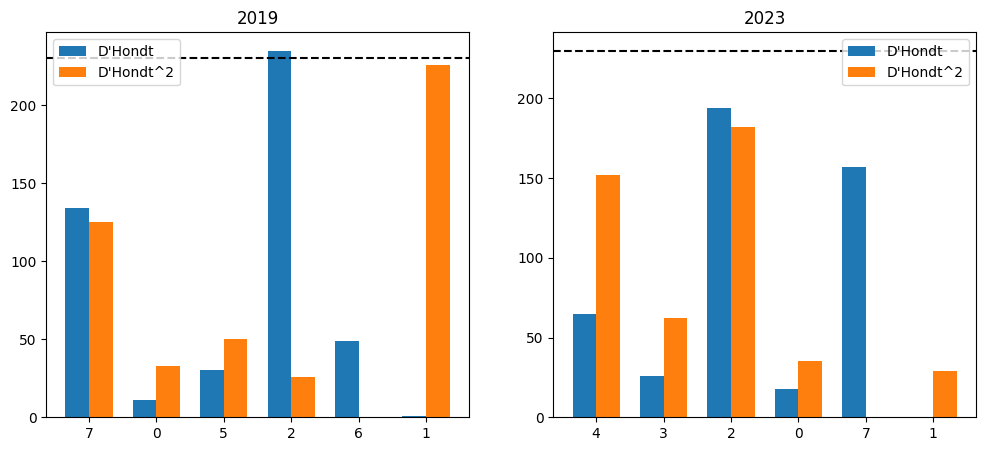

In [224]:
present_methods(ConstituencialDHondt, SquaredDHondt, "D'Hondt", "D'Hondt^2")

### Fair Vote Weight DHondt Method


0: KOMITET WYBORCZY KONFEDERACJA WOLNOŚĆ I NIEPODLEGŁOŚĆ
1: KOMITET WYBORCZY WYBORCÓW MNIEJSZOŚĆ NIEMIECKA
2: KOMITET WYBORCZY PRAWO I SPRAWIEDLIWOŚĆ
3: KOMITET WYBORCZY NOWA LEWICA
4: KOALICYJNY KOMITET WYBORCZY TRZECIA DROGA POLSKA 2050 SZYMONA HOŁOWNI - POLSKIE STRONNICTWO LUDOWE
5: KOMITET WYBORCZY POLSKIE STRONNICTWO LUDOWE
6: KOMITET WYBORCZY SOJUSZ LEWICY DEMOKRATYCZNEJ
7: KOALICYJNY KOMITET WYBORCZY KOALICJA OBYWATELSKA PO .N IPL ZIELONI


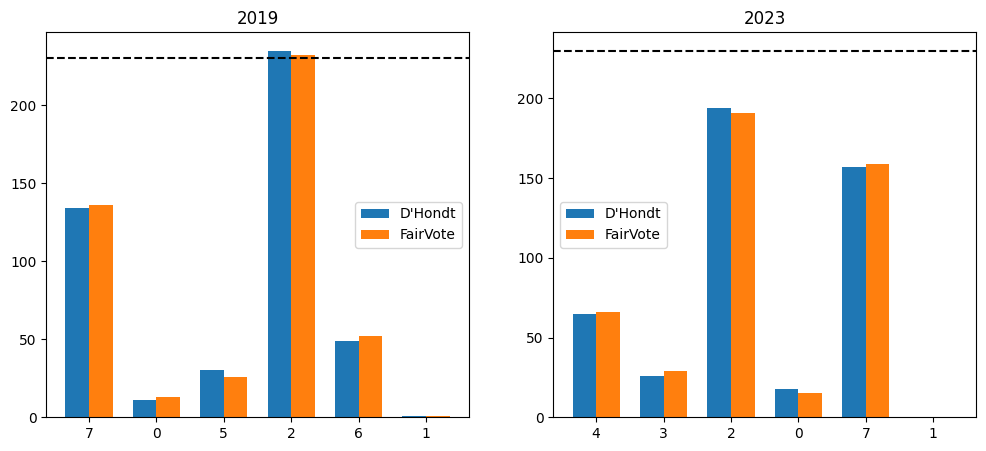

In [225]:
present_methods(ConstituencialDHondt, FairVoteWeightDHondt, "D'Hondt", "FairVote")